## **FDS project, winter semester 2023**

#### Tommaso Leonardi, Arianna Paolini, Stefano Saravalle, Paolo Cursi, Pietro Signorino
<leonardi.1914546@studenti.uniroma1.it>, <paolini.1943164@studenti.uniroma1.it>, <saravalle.1948684@studenti.uniroma1.it>, <paoloc1999@gmail.com>, <signorino.2149741@studenti.uniroma1.it>

# **Student Performance Analysis & Prediction**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### **Data Preprocessing**

In [2]:
#loading the dataset tables
courses = pd.read_csv('./data/courses.csv')  #22 rows for courses (modules) and their presentations
assess = pd.read_csv('./data/assessments.csv')  #206 rows of assessments for module-presentations (including the final exam)
results = pd.read_csv('./data/studentAssessment.csv') #173,912 rows for the scores obtained by students in the asssesments
studs = pd.read_csv('./data/studentInfo.csv') #32,593 rows for demographic information on students and their results in module-presentations
registr = pd.read_csv('./data/studentRegistration.csv') #32,593 rows for student registration/unregistration on module-presentations
vle = pd.read_csv('./data/studentVle.csv') #10,655,280 rows for daily student interactions with online resources for a module-presentation
materials = pd.read_csv('./data/vle.csv') #6,364 rows for the materials available on the Virtual Learning Environment

The _Open University Learning Analytics dataset_ that we are considering has the following structure: 

 <img src="https://analyse.kmi.open.ac.uk/resources/images/model.png" alt="dataset structure" style="height: 500px; width:500px;"/>


(https://analyse.kmi.open.ac.uk/open_dataset)



In [3]:
#DONE: definire i task -> regressione/classificazione dello score per ogni assessment
#DONE: trasformare valori categorici in numeri
#DONE: normalizzare i dati
#?: pulire i dati
#DONE: mostrare la distribuzione dei dati con grafici
#DONE: fare split tra training e test set (considerare cross validation)


Since our goal is to predict the score of each student in any assessment belonging to a specific module presentation, we consider the demographic information about students (from the table *studentInfo*) and their accessess to online resources in the Virtual Learning Environment (VLE) for each course (from the tables *studentVle* and *vle*) as features for our models. 

We also take in account the assessment type and weigth (from the table *assessments*) and the time the student spent before submitting it (from the table *studentAssessment*). 

The target value to predict is the score from the *studentAssessment* table, which ranges from 0 to 100.

In [4]:
#dropping some features
studs = studs.drop("final_result", axis=1)
registr = registr.drop("date_unregistration", axis=1)
materials = materials.drop(["week_from", "week_to"], axis=1)
vle = vle.drop("date", axis=1)
results = results.drop("is_banked", axis=1)

#remove Nan values in studs 'imd_band' (amounts to around 7000 total assessment results)
studs=studs.dropna()

#remove students with 'date registration' that is null (amounts to 7 total assessment results)
registr=registr.dropna()

#match info about a student and his date of registration to a module presentation
studs = studs.merge(registr, how="inner", on=["code_module", "code_presentation","id_student"])

#match a student's interactions with an online resource with the type of the resource
vle = vle.merge(materials, how="inner", on=["code_module", "code_presentation","id_site"] )
vle = vle.drop("id_site", axis=1)

#group the interactions by resource type and add a feature to consider the total sum of clicks for each resource type
temp = vle.groupby(["code_module", "code_presentation", "id_student", "activity_type"]).sum().reset_index()
for x in temp["activity_type"].unique():
    temp[x+"_clicks"] = np.where(temp["activity_type"]==x, temp["sum_click"], 0)
temp = temp.drop(["activity_type","sum_click"], axis=1)
temp = temp.groupby(["code_module", "code_presentation", "id_student"]).sum().reset_index()

#match student's information with his interactions on the VLE for a specific module presentation and fill nan with 0
studs = studs.merge(temp, how="left", on=["code_module", "code_presentation", "id_student"])
studs= studs.fillna(0)

#remove assessments without 'date'=nan and results with 'score'=nan
assess=assess.dropna()
results=results.dropna()
#a=results.merge(assess[assess['date'].isnull()], how="inner", on=["id_assessment"]) #only 2865 instances are removed

#match assessments with students scores
assess = assess.merge(results, how="inner", on="id_assessment")

#substitute date in assessment and date_submitted in results with their difference (to be considered as a time delay from expected submission)
assess["submission_delay"] = assess["date_submitted"] - assess["date"] #"date" is the deadline for the assessment
assess = assess.drop(["date","date_submitted"], axis=1)

#match students with their results
df = studs.merge(assess, how="inner", on=["code_module", "code_presentation","id_student"])

#remove ids from the features
df = df.drop(["code_module","code_presentation","id_student","id_assessment"], axis=1) 
print(df.shape) #163387 total rows

(163387, 33)


Some of the features in the dataset have *string* values (e.g. 'gender' has values {'M', 'F'}). 

We convert those features to integer values. The list *to_be_converted* contains the names of such features.

In [5]:
df["highest_education"] = df["highest_education"].replace({"No Formal quals":0, "Lower Than A Level":1, "A Level or Equivalent": 2, 
                                                           "HE Qualification":3, "Post Graduate Qualification":4 })

df["imd_band"] = df["imd_band"].replace({"0-10%":0, "10-20":1, "20-30%": 2, "30-40%":3, "40-50%":4, "50-60%":5,
                                          "60-70%":6, "70-80%":7, "80-90%":8, "90-100%":9 })

df["age_band"] = df["age_band"].replace({"0-35":0, "35-55":1, "55<=": 2})

to_be_converted = ["gender", "region", "disability", "assessment_type"]

for column_name in to_be_converted:

    values = set(df[column_name].tolist())
    print(f"Values in '{column_name}' column: {values}")

    mapping = {x : y for y,x in enumerate(values)}
    print(f"Mapping from string values to numerical using the following dictionary: {mapping}")

    df[column_name] = df[column_name].map(mapping)

    print("\n==================================================\n")


Values in 'gender' column: {'M', 'F'}
Mapping from string values to numerical using the following dictionary: {'M': 0, 'F': 1}


Values in 'region' column: {'Scotland', 'North Region', 'East Midlands Region', 'West Midlands Region', 'Ireland', 'London Region', 'South Region', 'South East Region', 'Wales', 'South West Region', 'Yorkshire Region', 'East Anglian Region', 'North Western Region'}
Mapping from string values to numerical using the following dictionary: {'Scotland': 0, 'North Region': 1, 'East Midlands Region': 2, 'West Midlands Region': 3, 'Ireland': 4, 'London Region': 5, 'South Region': 6, 'South East Region': 7, 'Wales': 8, 'South West Region': 9, 'Yorkshire Region': 10, 'East Anglian Region': 11, 'North Western Region': 12}


Values in 'disability' column: {'N', 'Y'}
Mapping from string values to numerical using the following dictionary: {'N': 0, 'Y': 1}


Values in 'assessment_type' column: {'TMA', 'Exam', 'CMA'}
Mapping from string values to numerical using the followin

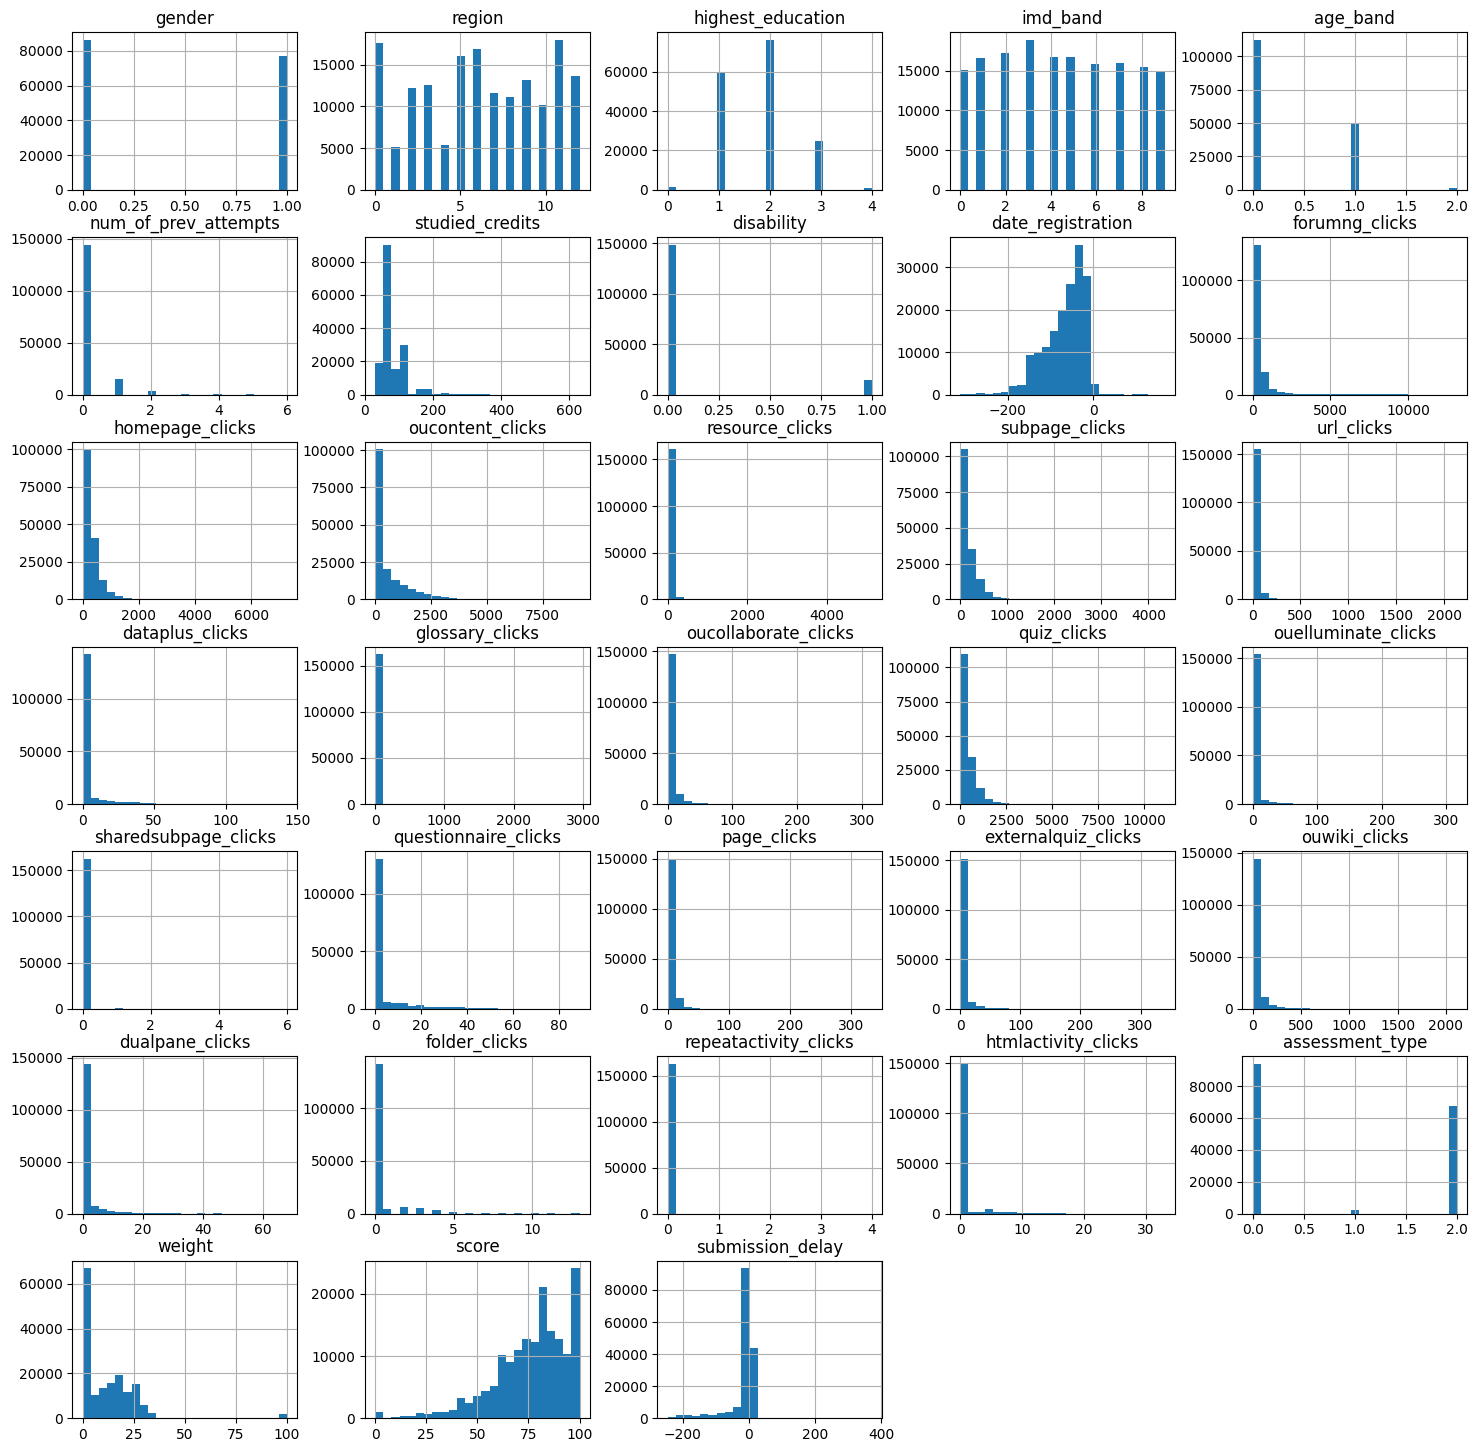

In [6]:
#showing the feature values
df.hist(layout=(7,5),figsize=(18, 18), bins=25)
plt.show()

With the previous step we have obtained a dataset containing only *integer values*.

We normalize every feature $f$ with values $vals$ and
- mean:  $mn$
- standard deviation:  $std$

with the following algorithm.

For each $v \in vals$:
$$
v := \frac{v - mn}{std}
$$

<!-- This step ensures that every value in the dataset is in the range $[0,1]$. -->

Let's also save the score for later computations using Neural Networks

In [7]:
y_nn = df["score"].tolist()

In [8]:
for col in df:
    print(f"Normalizing column '{col}'")
    print("\n==================================================\n")

    df[col] = (df[col] - df[col].mean()) / df[col].std()

Normalizing column 'gender'


Normalizing column 'region'


Normalizing column 'highest_education'


Normalizing column 'imd_band'


Normalizing column 'age_band'


Normalizing column 'num_of_prev_attempts'


Normalizing column 'studied_credits'


Normalizing column 'disability'


Normalizing column 'date_registration'


Normalizing column 'forumng_clicks'


Normalizing column 'homepage_clicks'


Normalizing column 'oucontent_clicks'


Normalizing column 'resource_clicks'


Normalizing column 'subpage_clicks'


Normalizing column 'url_clicks'


Normalizing column 'dataplus_clicks'


Normalizing column 'glossary_clicks'


Normalizing column 'oucollaborate_clicks'


Normalizing column 'quiz_clicks'


Normalizing column 'ouelluminate_clicks'


Normalizing column 'sharedsubpage_clicks'


Normalizing column 'questionnaire_clicks'


Normalizing column 'page_clicks'


Normalizing column 'externalquiz_clicks'


Normalizing column 'ouwiki_clicks'


Normalizing column 'dualpane_clicks'


Normali

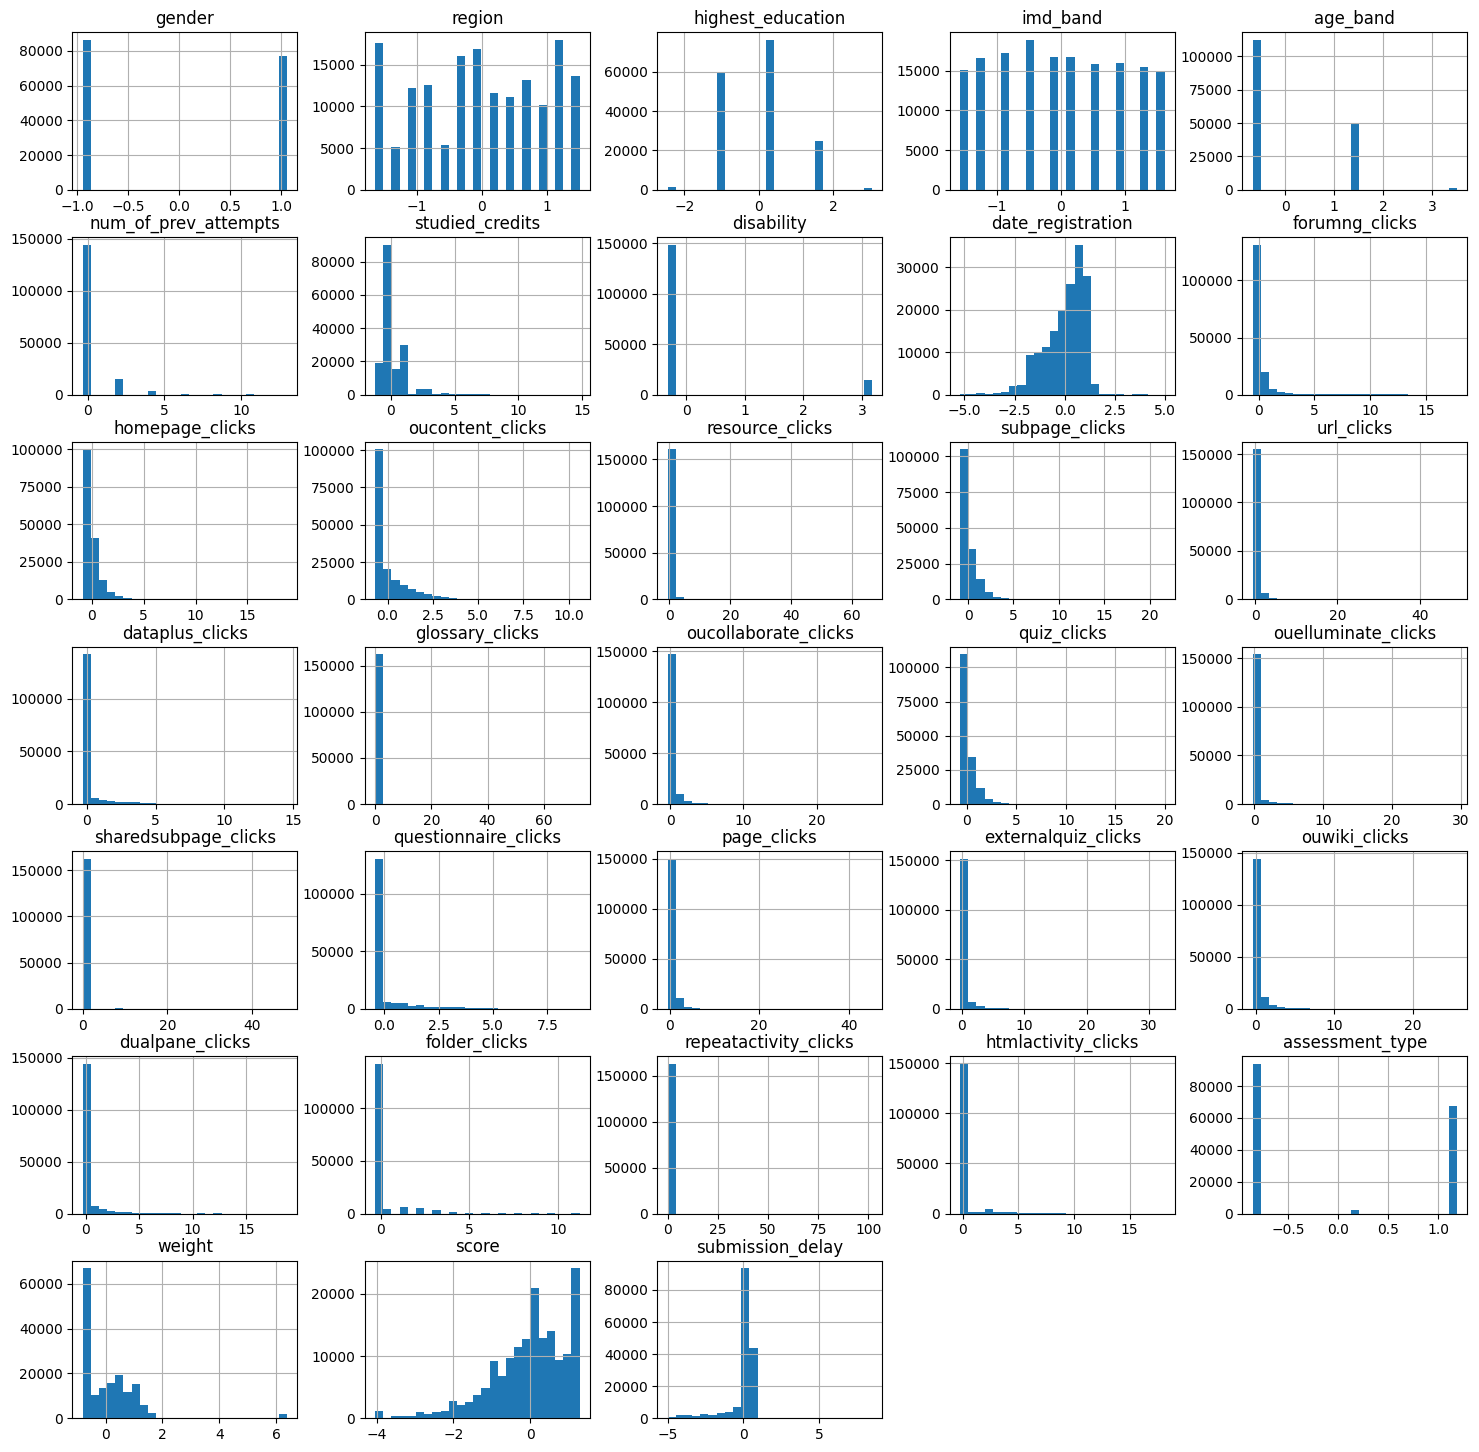

Column 'gender' has max value of 1.0586396604726935
Column 'region' has max value of 1.5080381978306316
Column 'highest_education' has max value of 3.0450965769712472
Column 'imd_band' has max value of 1.6279097821340263
Column 'age_band' has max value of 3.5125380037014544
Column 'num_of_prev_attempts' has max value of 13.007845039702666
Column 'studied_credits' has max value of 14.819496958952277
Column 'disability' has max value of 3.175616161701915
Column 'date_registration' has max value of 4.9770544172070315
Column 'forumng_clicks' has max value of 17.7757272371232
Column 'homepage_clicks' has max value of 18.820656142513954
Column 'oucontent_clicks' has max value of 10.597292648771141
Column 'resource_clicks' has max value of 66.56019757945391
Column 'subpage_clicks' has max value of 21.644176798963034
Column 'url_clicks' has max value of 49.08569973219772
Column 'dataplus_clicks' has max value of 14.55851262699177
Column 'glossary_clicks' has max value of 72.83521981498382
Colu

In [9]:
#showing the feature values after normalization
df.hist(layout=(7,5),figsize=(18, 18), bins=25)
plt.show()

for col in df:
    print(f"Column '{col}' has max value of {df[col].max()}")


In [10]:
df

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,date_registration,forumng_clicks,...,externalquiz_clicks,ouwiki_clicks,dualpane_clicks,folder_clicks,repeatactivity_clicks,htmlactivity_clicks,assessment_type,weight,score,submission_delay
0,-0.944603,1.245566,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.853274,-0.086882,0.117325,0.340851
1,-0.944603,1.245566,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.853274,0.632217,0.490268,0.340851
2,-0.944603,1.245566,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.853274,0.632217,0.223880,0.319025
3,-0.944603,1.245566,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.853274,0.632217,0.490268,0.319025
4,-0.944603,1.245566,1.670893,1.627910,3.512538,-0.32674,4.373748,-0.314898,-1.974627,-0.266182,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.853274,1.351317,0.330435,0.297199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163382,1.058640,0.983093,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,1.186536,-0.805982,1.289430,-0.881397
163383,1.058640,0.983093,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,1.186536,-0.805982,1.289430,-0.139318
163384,1.058640,0.983093,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.853274,-0.805982,0.223880,-0.161144
163385,1.058640,0.983093,1.670893,0.205043,1.424631,-0.32674,-1.250886,-0.314898,0.818840,-0.380327,...,-0.284227,-0.404455,-0.312504,-0.32809,-0.013092,-0.259839,-0.853274,-0.805982,0.223880,0.144418


We get the training and test sets for our ML models by splitting the dataset according to a given ratio between training and test samples. We choose to use 80% of the original number of samples for training and the remaining 20% for testing.

In [11]:
#using scikit-learn to split the dataset into train and test sets
X = df.drop("score", axis=1)
y = df["score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=0) #130709 train samples, 32678 test

### Neural Networks

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_nn, train_size=0.8, test_size=0.2, random_state=0) #130709 train samples, 32678 test

In [13]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
class StudentDataset(Dataset):

    def __init__(self, X, y, transform=None):
        self.X = X.values.tolist()
        self.y = y

    def __len__(self):
        return len(self.X)
        

    def __getitem__(self, idx):
        x_sample = torch.tensor(self.X[idx])
        y_sample = torch.zeros(101)
        y_sample[int(self.y[idx])] = 1

        return x_sample, y_sample
        

In [15]:
dataset_train = StudentDataset(X_train, y_train)
dataset_test = StudentDataset(X_test, y_test)

In [16]:
dataloader_train = DataLoader(dataset_train, batch_size=16,
                        shuffle=True, num_workers=0)

dataloader_test = DataLoader(dataset_test, batch_size=16,
                        shuffle=True, num_workers=0)

In [17]:
x, y = dataset_train[0]
in_features = len(x)
out_features = len(y)

In [18]:
class StudentScoreClassifier(nn.Module):
    def __init__(self):
        super(StudentScoreClassifier, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features, in_features * 4),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features*4, in_features*8),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features*8, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [19]:
device = "cuda" if torch.cuda.is_available else "cpu"

model = StudentScoreClassifier().to(device)
epochs = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [20]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    corrects = 0.0
    for i, data in enumerate(dataloader_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        _, preds = torch.max(outputs.data, 1)
        _, correct_labels = torch.max(labels.data ,1)

        corrects += float(torch.sum(preds == correct_labels))
    
    print(f"EPOCH {epoch+1} \t LOSS: {running_loss/len(dataset_train)} \t ACCURACY: {corrects/len(dataset_train)}")

print('Finished Training')

EPOCH 1 	 LOSS: 0.2653157996126666 	 ACCURACY: 0.10998477534064219
EPOCH 2 	 LOSS: 0.2620515628210108 	 ACCURACY: 0.11537843606790657
EPOCH 3 	 LOSS: 0.2612109068912782 	 ACCURACY: 0.116143494327093
EPOCH 4 	 LOSS: 0.2608216562379758 	 ACCURACY: 0.11498825635572149
EPOCH 5 	 LOSS: 0.260613510188031 	 ACCURACY: 0.11266247924779473
EPOCH 6 	 LOSS: 0.2604259903831188 	 ACCURACY: 0.10977820961066186
EPOCH 7 	 LOSS: 0.26025987193853106 	 ACCURACY: 0.10210467527102189
EPOCH 8 	 LOSS: 0.25992212027835965 	 ACCURACY: 0.09318409596890803
EPOCH 9 	 LOSS: 0.2597344800083057 	 ACCURACY: 0.11188977040601641
EPOCH 10 	 LOSS: 0.2595295331238604 	 ACCURACY: 0.11301440604702048
EPOCH 11 	 LOSS: 0.25933950533549244 	 ACCURACY: 0.11279253915185641
EPOCH 12 	 LOSS: 0.2591165096544249 	 ACCURACY: 0.11332042935069506
EPOCH 13 	 LOSS: 0.25895362122534266 	 ACCURACY: 0.11388657246249302
EPOCH 14 	 LOSS: 0.2587253814317836 	 ACCURACY: 0.11550849597196826
EPOCH 15 	 LOSS: 0.258529751750748 	 ACCURACY: 0.1148658

KeyboardInterrupt: 

In [29]:
torch.cuda.empty_cache()